#Density Sensitive projection

In [31]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams


# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

# Define some functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)    
    return 0

def hashWithMedianPlane(p, x):
    """ hash using median plane
    """
    w = p[0] - p[1]
    t = np.dot((p[0]+p[1])/2,w)
    
    res = np.inner(w, X)    
    
    return ['1' if elem >= t else '0' for elem in res]


def medianPlane(p):
    """Generate median plane given two points
    """    
    median = (p[0]+p[1]) / 2
    diff = p[0] - p[1]
    
    # hyperplane    
    intercept = -np.dot(median,diff)    

    return (diff, intercept)

def generateBitString( x ):
    return "".join(['1' if i > 0 else '0' for i in x])

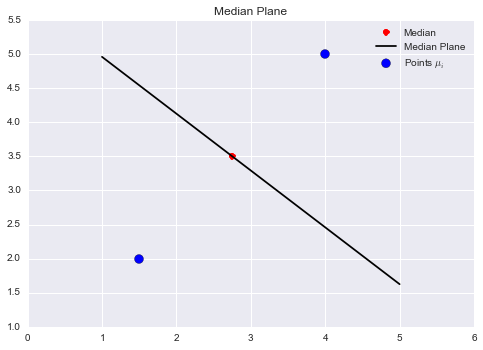

In [32]:
# Show the base of the algorithm
p = np.array( [ (1.5,2), (4,5) ] )

plt.scatter(p[:, 0], p[:, 1], s=80,
                 zorder=10, label='Points $\mu_i$')

# median of the centers
median = (p[0]+p[1]) / 2
diff = p[0] - p[1]
plt.plot(median[0],median[1], 'ro', label='Median')

# hyperplane
a = -diff[0] / diff[1]
intercept = -np.dot(median,diff)

xx = np.linspace(1, 5)
yy = a * xx - (intercept) / diff[1]

plt.plot(xx, yy, 'k-', label='Median Plane')
plt.title('Median Plane')
plt.legend()
plt.show()

Define Median Plane as $(x - \frac{\mu_i+\mu_j}{2})^T (\mu_i - \mu_j) = 0$

In [33]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 200
n_samples_2 = 200
X = np.r_[1 * rng.randn(n_samples_1, 2) - [2,2],
          1 * rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

[(154.0, '1', 154, 190), (164.0, '0', 46, 210)]
[(46.0, '01', 46, 47)]
[(4.0, '010', 4, 5)]
[(1.0, '0100', 1, 2)]
No more elements


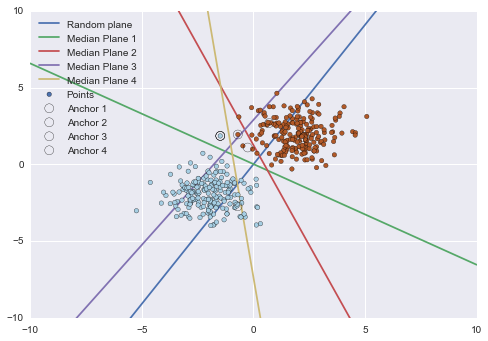

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')

# Now generate a random plane through the origin - start of the algorithm
randomProjection = random_projection.gaussian_random_matrix(1, 2, random_state=rng)
plotHyperplane(randomProjection[0], label='Random plane')

# Project #1
projected = np.dot(X, randomProjection.T)

buckets = np.apply_along_axis( generateBitString, axis=1, arr=projected )

plane = 1

# medians stores the hyperplane normals as well as intercepts
medians = [(randomProjection[0], 0)]

# This is the algorithm
while True:  
    
    # concat both buckets and labels to group by
    data = np.column_stack((buckets, Y))    
    
    heap = []
    for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
        # estimate pos ratio
        l = list(rows)    
        length = len(l)    
        pos = len(list(filter(lambda x: x[1] == '1', l)))
        ratio = max(pos / length, (length-pos) / length)
        if 0.5 <= ratio < 1:
            # Take buckets which need splitting - weight them by the number of points
            heap.append(( length * ratio, key, pos, length))    
    
    if (len(heap) == 0) or (plane > 20) :
        print('No more elements')
        break;
        
    heap = sorted(heap, key=lambda x: x[0])        
        
    print(heap)
    
    # get the smalles element 
    largest = heap[0]#.pop()

    # 2 strategies
    # Take random points 1) or 2) take the median of all pos/neg points each, simulates k-means
    
    # now from this "largest bucket" sample 1 pos and 1 neg point
    #qualifyingPos = random.choice(X[(buckets == largest[1]) & (Y == 1)])
    #qualifyingNeg = random.choice(X[(buckets == largest[1]) & (Y == 0)])
    
    # Strategy 2 take median of qualifying points
    qualifyingPos = np.median(X[(buckets == largest[1]) & (Y == 1)],axis=0)
    qualifyingNeg = np.median(X[(buckets == largest[1]) & (Y == 0)],axis=0)
        
    median = (qualifyingPos, qualifyingNeg)

    plt.scatter([qualifyingPos[0],qualifyingNeg[0]], [qualifyingPos[1],qualifyingNeg[1]], s=80,
                    facecolors='none', zorder=10, label='Anchor ' + str(plane))

    (point, intercept) = medianPlane(median)

    # Store the median points
    medians.append((point, intercept))
    
    plotHyperplane(point, intercept, 'Median Plane ' + str(plane))
    
    # add the new bitstring to the hash
    buckets = np.core.defchararray.add(buckets, hashWithMedianPlane(median, X))
    
    plane = plane + 1
    
    
plt.legend(loc='upper left')
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.show()

Generate Hamming points and label based on majority

In [35]:
keySize = len(list(groupby(data[np.argsort(data[:,0])], lambda x: x[0])))

X_hamming = np.empty([keySize, len(buckets[0])])
Y_hamming = [0] * keySize
counter = 0

for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    row = list(rows)        
    pos = len(list(filter(lambda x: x[1] == '1', row)))
    neg =  len(list(filter(lambda x: x[1] == '0', row)))
    X_hamming[counter:] = np.array(list(map(int, key))) 
    Y_hamming[counter] = 1 if pos > neg else 0
    counter = counter + 1   
    
# Create Hamming Points and run SVM
clf = svm.SVC(kernel='linear')
clf.fit(X_hamming, Y_hamming)

#print('Support Vectors:\n', clf.support_vectors_)
print('All hamming points %d - reduced to %d' % (keySize, len(clf.support_vectors_)))

All hamming points 10 - reduced to 5


##The algorithm

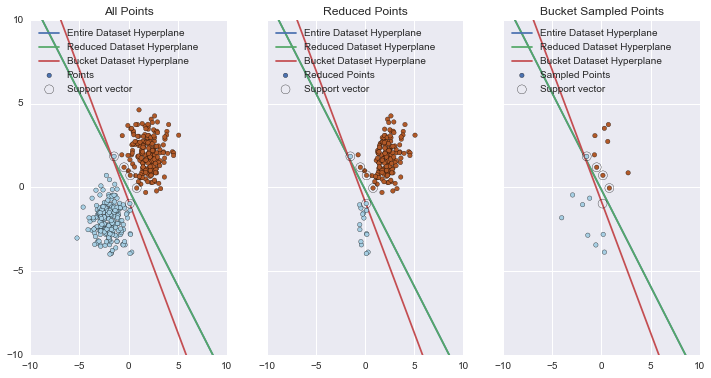

We have 5 support vectors in hamming space 
Stats
All points 400 - reduced points 174  56.50 % - bucket sampled 18 (0.04 %)


In [36]:
selected = np.apply_along_axis( generateBitString, axis=1, arr=clf.support_vectors_)

reduced_x = X[np.in1d(buckets, selected)]
reduced_y = Y[np.in1d(buckets, selected)]

# Also just sample 1 point from all buckets
sampledPoints = []
data = np.column_stack((buckets, X, Y))   
for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    #sampledPoints.append(random.choice(list(rows)))
    l = list(rows)
    sampledPoints.extend(random.sample(l,min(2,len(l))))

sampledPoints = np.asarray(sampledPoints)     
    
rcParams['figure.figsize'] = (12.0, 6.0)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, sharex=True)

# Now check if we still hit the same accuray
entire = svm.SVC(kernel='linear')
entire.fit(X,Y)
reduced = svm.SVC(kernel='linear')
reduced.fit(reduced_x, reduced_y)
bSampled = svm.SVC(kernel='linear')
bSampled.fit(sampledPoints[:, [1,2]].astype(float), sampledPoints[:,3].astype(int))

ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
ax1.set_title('All Points')

ax2.scatter(reduced_x[:, 0], reduced_x[:, 1], c=reduced_y, zorder=10, cmap=plt.cm.Paired, label='Reduced Points')
ax2.set_title('Reduced Points')

ax3.scatter(sampledPoints[:, 1], sampledPoints[:, 2], c=sampledPoints[:,3].astype(int),
            zorder=10, cmap=plt.cm.Paired, label='Sampled Points')
ax3.set_title('Bucket Sampled Points')


for plot in [ax1, ax2, ax3]: 
    plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset Hyperplane')
    plotHyperplane(reduced.coef_[0],reduced.intercept_[0], plt=plot, label='Reduced Dataset Hyperplane')
    plotHyperplane(bSampled.coef_[0],bSampled.intercept_[0], plt=plot, label='Bucket Dataset Hyperplane')
    plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, label='Support vector')
    
    plot.legend(loc='upper left')
    
plt.xlim([-10,10])
plt.ylim([-10,10])    
plt.show()


print('We have %d support vectors in hamming space ' % (len(entire.support_vectors_)))

print('Stats\nAll points %d - reduced points %d  %.2f %% - bucket sampled %d (%.2f %%)' % 
      (len(X), len(reduced_x), (1 - len(reduced_x)/len(X)) * 100, len(sampledPoints), len(sampledPoints)/len(X)))

In [37]:
# Now check if we still hit the same accuray

print ('Classification accuracy on the entire dataset with all     points %f ' % (entire.score(X,   Y)))
print ('Classification accuracy on the entire dataset with reduced points %f ' % (reduced.score(X,  Y)))
print ('Classification accuracy on the entire dataset with buckets points %f ' % (bSampled.score(X, Y)))

Classification accuracy on the entire dataset with all     points 0.997500 
Classification accuracy on the entire dataset with reduced points 0.997500 
Classification accuracy on the entire dataset with buckets points 0.995000 
